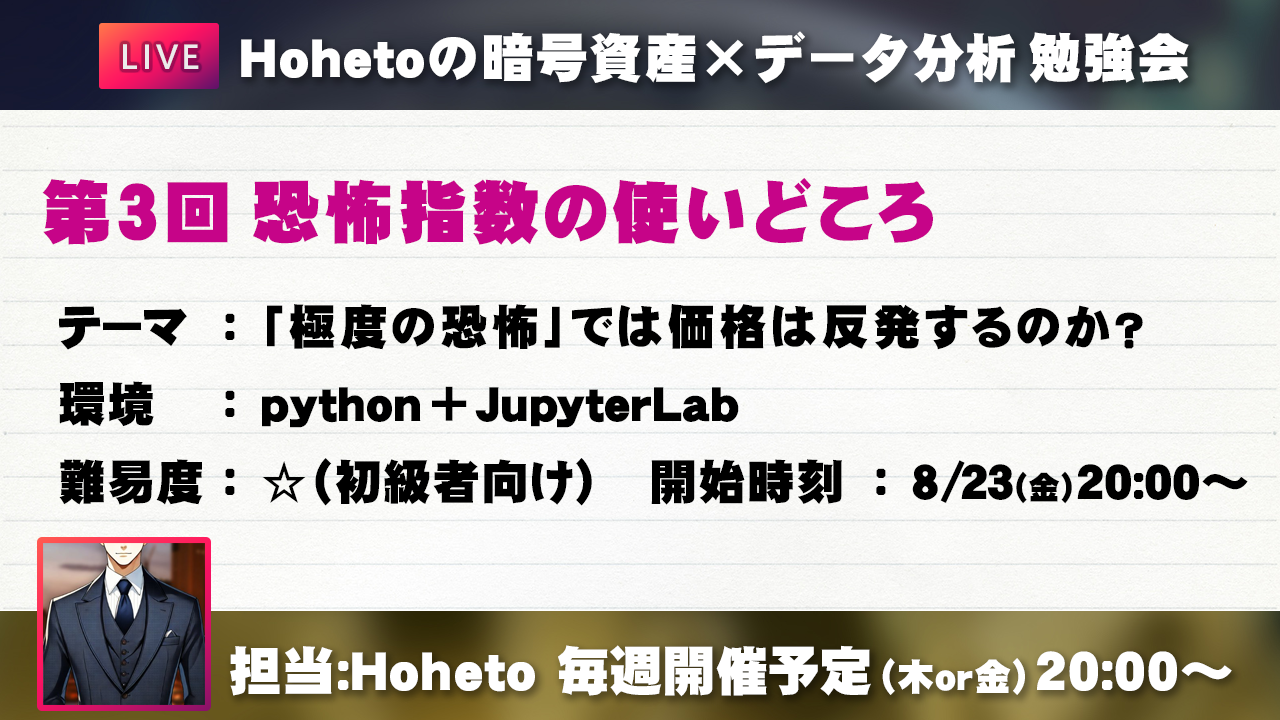

In [1]:
from IPython.display import Image

Image('./images/03_00.png')

# Hoheto勉強会 第3回 恐怖指数の使いどころ

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 恐怖指数とは
  - 一般的にはVIXで知られている。
  - 通常、オプションのインプライドボラティリティをもとに計算される（＝投資家が今後の市場のボラティリティをどの程度と予測しているかを示す）。
  - 投資家の市場に対する不安や恐怖の度合いを示す指数。
- 暗号資産では、恐怖指数は数か所で確認できる。
  - DVOL、BitVolなど
    - Deribitのビットコインオプションデータを用いて計算されたVolatility Index
  - Fear and Greed Index
    - Coinglassなどの独自データ

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 暗号資産における恐怖指数やVolatility Indexの概要
- これらの指標の取得方法
- 恐怖指数を利用した戦略の検討
- など

- 難易度☆1つ。

### 元ネタ

- Xはネタの宝庫！今回のネタは・・・

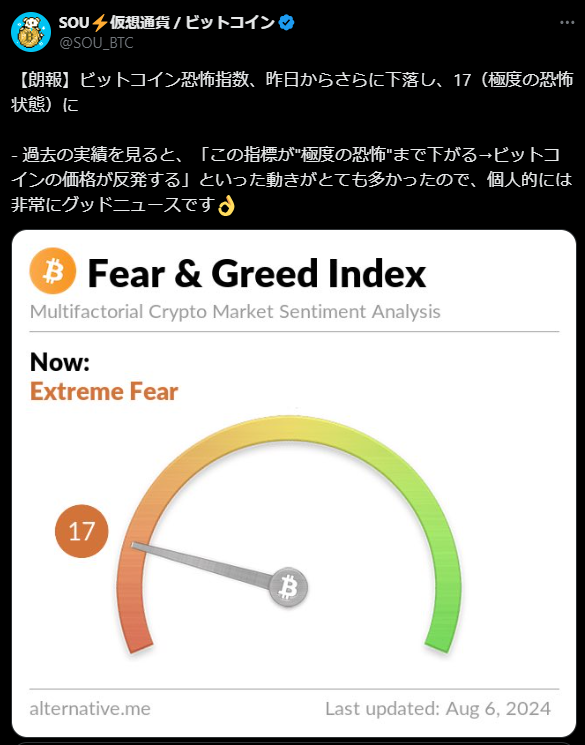

In [2]:
# https://twitter.com/SOU_BTC/status/1820625629857141242
Image('./images/03_01.png')

# 今回の検証の流れ

- Volatility IndexとFear and Greed Index
  - それぞれの取得方法
  - それぞれの違い
- 検証①　Volatility Index
- 検証②　Fear and Greed Index

# 環境設定

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# !pip install japanize-matplotlib
# !pip install tqdm

import japanize_matplotlib
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
import seaborn as sns
import time
import traceback
import warnings

from datetime import datetime, timedelta
from dateutil import parser
from IPython.display import display, Image
from scipy import stats
from tqdm import tqdm

In [5]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データ取得

## BTCUSDTの取得

- BTCUSDTの無期限先物を利用したかったが、2017～のデータがほしいので現物のデータを取得。

In [6]:
def fetch_binance_spot_candles(symbol, from_date, to_date):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    interval = '1d'
    resolution = 60 * 60 * 24
    limit = 1000
    endpoint = 'https://api.binance.com/api/v3/klines'
    start_time = from_time
    kline_list = []
    while True:
        end_time = start_time + resolution * 1000 * limit - 1
        if end_time > to_time:
            end_time = to_time
        params={'symbol': symbol, 'startTime': start_time, 'endTime': end_time, 'interval': interval, 'limit': limit}
        kline = requests.get(endpoint, params).json()
        kline = pd.DataFrame(kline).astype(float)
        kline.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time', 'quote_volume', 'trade_num', 'buy_volume', 'quote_buy_volume', 'ignore1']
        kline.index = pd.to_datetime(kline['open_time'] / 1000, unit='s', utc=True)
        kline_list.append(kline)
        if end_time == to_time:
            break
        start_time = end_time + 1
    return pd.concat(kline_list, axis=0).sort_index()

In [7]:
btcusdt = fetch_binance_spot_candles(symbol='BTCUSDT', from_date='2017-01-01', to_date='2024-08-21')

- 2017/8/17～

In [8]:
btcusdt

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_volume,trade_num,buy_volume,quote_buy_volume,ignore1
open_time,,,,,,,,,,,,
2017-08-17 00:00:00+00:00,1.502928e+12,4261.48,4485.39,4200.74,4285.08,795.150377,1.503014e+12,3.454770e+06,3427.0,616.248541,2.678216e+06,0.0
2017-08-18 00:00:00+00:00,1.503014e+12,4285.08,4371.52,3938.77,4108.37,1199.888264,1.503101e+12,5.086958e+06,5233.0,972.868710,4.129123e+06,0.0
2017-08-19 00:00:00+00:00,1.503101e+12,4108.37,4184.69,3850.00,4139.98,381.309763,1.503187e+12,1.549484e+06,2153.0,274.336042,1.118002e+06,0.0
2017-08-20 00:00:00+00:00,1.503187e+12,4120.98,4211.08,4032.62,4086.29,467.083022,1.503274e+12,1.930364e+06,2321.0,376.795947,1.557401e+06,0.0
2017-08-21 00:00:00+00:00,1.503274e+12,4069.13,4119.62,3911.79,4016.00,691.743060,1.503360e+12,2.797232e+06,3972.0,557.356107,2.255663e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-17 00:00:00+00:00,1.723853e+12,58874.59,59700.00,58785.05,59491.99,7721.729310,1.723939e+12,4.577377e+08,807159.0,3871.653100,2.294775e+08,0.0
2024-08-18 00:00:00+00:00,1.723939e+12,59491.99,60284.99,58408.92,58427.35,13634.857170,1.724026e+12,8.131666e+08,1099730.0,6660.582540,3.974595e+08,0.0
2024-08-19 00:00:00+00:00,1.724026e+12,58427.35,59617.63,57787.30,59438.50,22809.312510,1.724112e+12,1.336288e+09,1636295.0,11350.307760,6.650662e+08,0.0


In [9]:
# 欠損チェック.
btcusdt.isnull().any()

open_time           False
open_price          False
high_price          False
low_price           False
close_price         False
volume              False
close_time          False
quote_volume        False
trade_num           False
buy_volume          False
quote_buy_volume    False
ignore1             False
dtype: bool

In [10]:
# 統計量チェック
btcusdt.describe()

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_volume,trade_num,buy_volume,quote_buy_volume,ignore1
count,2.562000e+03,2562.000000,2562.000000,2562.000000,2562.000000,2562.000000,2.562000e+03,2.562000e+03,2.562000e+03,2562.000000,2.562000e+03,2562.0
mean,1.613563e+12,24456.074524,25064.231831,23791.657486,24478.338860,70015.540944,1.613650e+12,1.682060e+09,1.466555e+06,34816.838559,8.334433e+08,0.0
std,6.391267e+10,19090.875951,19535.981535,18600.515963,19100.494938,81600.650389,6.391272e+10,2.007098e+09,1.920666e+06,40598.795924,9.973807e+08,0.0
min,1.502928e+12,3188.010000,3276.500000,2817.000000,3189.020000,228.108068,1.503014e+12,9.778657e+05,2.153000e+03,56.190141,2.413638e+05,0.0
25%,1.558246e+12,8227.037500,8457.250000,8010.767500,8227.152500,28990.806891,1.558332e+12,3.119701e+08,3.292598e+05,14535.023958,1.596933e+08,0.0
50%,1.613563e+12,19058.870000,19403.455000,18500.135000,19064.695000,44658.604205,1.613650e+12,9.243843e+08,8.686450e+05,22294.390176,4.438686e+08,0.0
75%,1.668881e+12,38274.572500,39556.802500,37166.250000,38316.100000,73938.101292,1.668967e+12,2.393936e+09,1.659100e+06,36370.799592,1.177232e+09,0.0
max,1.724198e+12,73072.400000,73777.000000,71333.310000,73072.410000,760705.362783,1.724285e+12,1.746531e+10,1.522359e+07,374775.574085,8.783916e+09,0.0


In [11]:
# 抜け漏れチェック
pd.DatetimeIndex(pd.date_range(btcusdt.index.min(), btcusdt.index.max())).difference(btcusdt.index)

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')

# Volatility Index

- DVOL
  - オプション取引所Deribitが提供するVolatility Index。
  - チャート [ https://www.deribit.com/statistics/BTC/volatility-index/ ]
  - 計算方法 [ https://insights.deribit.com/exchange-updates/dvol-deribit-implied-volatility-index/ ]
  - IV Rank IVランクは、現在のIVレベルが過去1年間のIVの範囲内のどの位置にあるかを示している。
- BitVOL
  - ビットコインの30日間インプライドボラティリティ。→DeribitのDVOLと基本同じ。
  - チャート [ https://t3index.com/indexes/bit-vol/ ]

## DVOLの取得

In [12]:
import requests
from dateutil import parser

def fetch_dvol(currency, from_date, to_date):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    resolution = 60 * 60 * 24  # 日足
    limit = 1000
    endpoint = 'https://www.deribit.com/api/v2/public/get_volatility_index_data'
    start_time = from_time
    dvol_list = []
    while True:
        end_time = start_time + resolution * 1000 * limit - 1
        if end_time > to_time:
            end_time = to_time
        params={'currency': currency, 'start_timestamp': start_time, 'end_timestamp': end_time, 'resolution': resolution}
        dvol = requests.get(endpoint, params).json()['result']['data']
        dvol = pd.DataFrame(dvol, columns=['time', 'dvol_open', 'dvol_high', 'dvol_low', 'dvol_close'])
        dvol.index = pd.to_datetime(dvol['time'] / 1000, unit='s', utc=True)
        dvol_list.append(dvol)
        if end_time == to_time:
            break
        start_time = end_time + 1
    return pd.concat(dvol_list, axis=0).sort_index()


In [13]:
df_dvol = fetch_dvol(currency='BTC', from_date='2017-01-01', to_date='2024-08-21')

- 2021/3/24～

In [14]:
df_dvol

,time,dvol_open,dvol_high,dvol_low,dvol_close
time,,,,,
2021-03-24 00:00:00+00:00,1616544000000,84.80,95.94,80.52,95.04
2021-03-25 00:00:00+00:00,1616630400000,95.03,97.43,87.25,89.74
2021-03-26 00:00:00+00:00,1616716800000,89.74,89.74,80.22,84.52
2021-03-27 00:00:00+00:00,1616803200000,84.52,84.60,77.81,79.69
2021-03-28 00:00:00+00:00,1616889600000,79.69,81.28,78.20,79.07
...,...,...,...,...,...
2024-08-17 00:00:00+00:00,1723852800000,53.12,53.87,52.30,53.71
2024-08-18 00:00:00+00:00,1723939200000,53.71,55.72,53.67,55.32
2024-08-19 00:00:00+00:00,1724025600000,54.40,54.44,53.67,53.68


In [15]:
# 欠損チェック.
df_dvol.isnull().any()

time          False
dvol_open     False
dvol_high     False
dvol_low      False
dvol_close    False
dtype: bool

In [16]:
# 統計量チェック
df_dvol.describe()

,dvol_open,dvol_high,dvol_low,dvol_close
count,1247.000000,1247.000000,1247.000000,1247.000000
mean,67.805581,70.095630,65.535613,67.824058
std,19.055243,20.199505,18.214987,19.090329
min,32.380000,32.740000,31.410000,32.380000
25%,53.385000,54.850000,52.000000,53.385000
50%,65.220000,67.640000,62.820000,65.170000
75%,82.260000,84.205000,79.730000,82.260000
max,156.200000,167.830000,138.110000,156.200000


In [17]:
# 抜け漏れチェック
pd.DatetimeIndex(pd.date_range(df_dvol.index.min(), df_dvol.index.max())).difference(df_dvol.index)

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')

### プロット

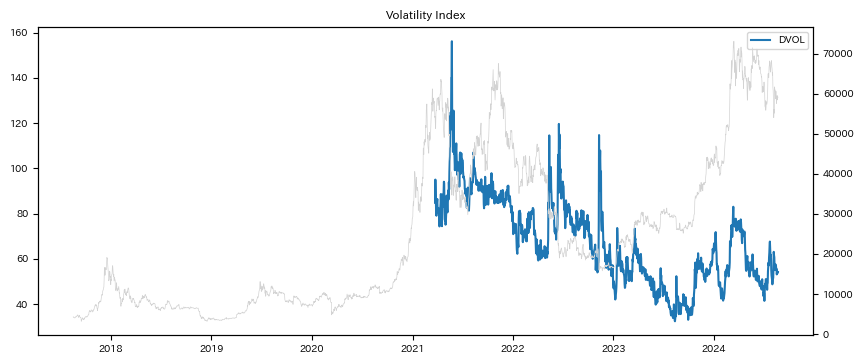

In [18]:
fig = plt.figure(figsize=(10, 4))
plt.title('Volatility Index')
ax = fig.gca()
ax.plot(df_dvol['dvol_open'], label='DVOL')
ax.legend()
ax.twinx().plot(btcusdt['open_price'], color='lightgray', lw=0.5);

- なんだかんだいってボラティリティは下がってきている。
- 時期に応じて値の範囲が異なるので、何らかの標準化が必要。

- 上昇局面よりも下落局面で高まっているように見受けられる。
- 下落時に大きく価格変化の起こる性質から来ているのかも（ネガティブスキュー）
- ただし、上昇局面でも高まっていることに注意。

# Fear and Greed Index（恐怖・強欲指数）

- X上でたまに見かける恐怖指数。
- alternative.meというサイトで公開されている。
- Coinglassでも公開されている。
- 説明と過去データを見る限りこの2つは同一のもの。どちらがオリジナルか、あるいは別に提供元があるのかはよくわからない。

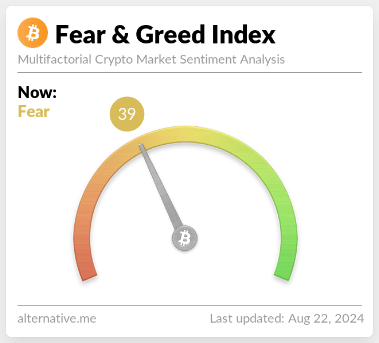

In [19]:
# alternative.meの恐怖指数
Image('./images/03_02.png')

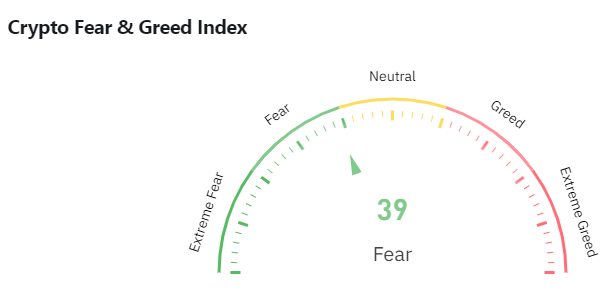

In [20]:
# Coinglassの恐怖指数
Image('./images/03_03.png')

- 計算方法 [ https://www.coinglass.com/ja/pro/i/FearGreedIndex ] [ https://alternative.me/crypto/fear-and-greed-index/ ]
- 5つのデータソースを用いている（以下、意訳）。
- ボラティリティ
  - 価格のボラティリティと最大ドローダウンについて、過去30日間と90日間で比較して算出。ボラの上昇＝恐怖としている。
- 出来高
  - 出来高を過去30日間と90日間で比較。プラスの日足で大量の買いが入っている場合、強欲としている。
- ソーシャルメディア上のセンチメント
  - X（旧twitter）上でのセンチメント分析。
  - 各コインのハッシュタグで投稿を収集し、そのインタラクションを確認。インタラクションが異常に高ければ強欲とする。
- ドミナンス
  - 市場全体の時価総額におけるビットコインとその他アルトコインのシェア。
  - ビットコインのシェアが多い（アルトコインから退避されている）場合は恐怖とする。
  - アルトコインのシェアが多い場合は強欲とする。
- Google Trend
  - 様々なビットコイン関連の検索クエリのGoogle Trendsのデータを取得。
  - 検索ボリュームの変化を確認するのと関連ワードのセンチメント（例えば「価格操作」のようなコメントは恐怖とする）

## F&Gの取得

In [21]:
fng = requests.get('https://api.alternative.me/fng/?limit=5000').json()['data']
df_fng = pd.DataFrame(fng)
df_fng['value'] = df_fng['value'].astype(float)
df_fng['timestamp'] = pd.to_datetime(df_fng['timestamp'].astype(float), unit='s', utc=True)
df_fng = df_fng.set_index('timestamp').sort_index()

- 2018/2/1～

In [22]:
df_fng

,value,value_classification,time_until_update
timestamp,,,
2018-02-01 00:00:00+00:00,30.0,Fear,NaN
2018-02-02 00:00:00+00:00,15.0,Extreme Fear,NaN
2018-02-03 00:00:00+00:00,40.0,Fear,NaN
2018-02-04 00:00:00+00:00,24.0,Extreme Fear,NaN
2018-02-05 00:00:00+00:00,11.0,Extreme Fear,NaN
...,...,...,...
2024-08-20 00:00:00+00:00,30.0,Fear,NaN
2024-08-21 00:00:00+00:00,26.0,Fear,NaN
2024-08-22 00:00:00+00:00,39.0,Fear,NaN


In [23]:
# 不要カラムを削除.
df_fng = df_fng.drop(columns=['time_until_update'])

In [24]:
# 欠損チェック.
df_fng.isnull().any()

value                   False
value_classification    False
dtype: bool

In [25]:
# 統計量チェック.
df_fng['value'].describe()

count    2394.000000
mean       46.063074
std        21.784392
min         5.000000
25%        27.000000
50%        44.000000
75%        64.000000
max        95.000000
Name: value, dtype: float64

In [26]:
# 抜け漏れチェック.
pd.DatetimeIndex(pd.date_range(df_fng.index.min(), df_fng.index.max())).difference(df_fng.index)

DatetimeIndex(['2018-04-14 00:00:00+00:00', '2018-04-15 00:00:00+00:00',
               '2018-04-16 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

- 抜け漏れがあるのでどうにかする。

### 欠損値対応

In [27]:
# 抜けている箇所の前後をチェック.
df_fng['2018-04-10':'2018-04-20']

,value,value_classification
timestamp,,
2018-04-10 00:00:00+00:00,18.0,Extreme Fear
2018-04-11 00:00:00+00:00,20.0,Extreme Fear
2018-04-12 00:00:00+00:00,18.0,Extreme Fear
2018-04-13 00:00:00+00:00,23.0,Extreme Fear
2018-04-17 00:00:00+00:00,26.0,Fear
2018-04-18 00:00:00+00:00,24.0,Extreme Fear
2018-04-19 00:00:00+00:00,25.0,Extreme Fear
2018-04-20 00:00:00+00:00,26.0,Fear


In [28]:
# 新たにインデックスを振ってdfを作り直し.
df_fng = pd.DataFrame(df_fng, index=pd.DatetimeIndex(pd.date_range(df_fng.index.min(), df_fng.index.max())))

In [29]:
# 欠損レコードにNan値が入ったdfができた.
df_fng['2018-04-10':'2018-04-20']

,value,value_classification
2018-04-10 00:00:00+00:00,18.0,Extreme Fear
2018-04-11 00:00:00+00:00,20.0,Extreme Fear
2018-04-12 00:00:00+00:00,18.0,Extreme Fear
2018-04-13 00:00:00+00:00,23.0,Extreme Fear
2018-04-14 00:00:00+00:00,NaN,NaN
2018-04-15 00:00:00+00:00,NaN,NaN
2018-04-16 00:00:00+00:00,NaN,NaN
2018-04-17 00:00:00+00:00,26.0,Fear
2018-04-18 00:00:00+00:00,24.0,Extreme Fear
2018-04-19 00:00:00+00:00,25.0,Extreme Fear


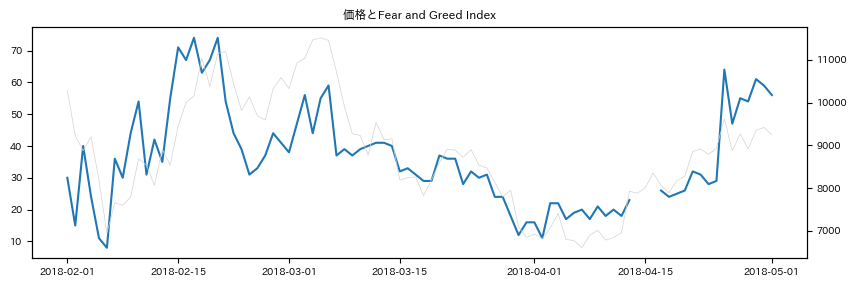

In [30]:
# 価格と合わせてプロット.
fig = plt.figure(figsize=(10, 3))
plt.title('価格とFear and Greed Index')
plt.plot(df_fng['2018-02-01':'2018-05-01']['value'])
ax = fig.gca()
ax.twinx().plot(btcusdt['2018-02-01':'2018-05-01']['open_price'], color='lightgray', lw=0.5);

- まずはvalueカラムの補完を行う。明らかに価格と連動していることが分かる。
- 線形モデルを使って欠損値を補完する。
- 今回はopen_priceのみを使う。ちゃんとやるなら4本値とか直近ボラティリティとかを使う。

In [31]:
from sklearn.linear_model import LinearRegression

# 近傍のデータで線形モデルを学習させる。
model = LinearRegression()
X_train = btcusdt['2018-02-01':'2018-04-13'][['open_price']]
y_train = df_fng['2018-02-01':'2018-04-13']['value']
model.fit(X_train, y_train)

# 欠損値を予測する
y_predict = model.predict(btcusdt['2018-04-14':'2018-04-16'][['open_price']])
y_predict

array([27.17888285, 28.24410357, 31.19989743])

In [32]:
# 欠損していたところに代入.
df_fng.loc['2018-04-14':'2018-04-16', 'value'] = y_predict

In [33]:
# valueカラムの欠損が埋められた.
df_fng['2018-04-10':'2018-04-20']

,value,value_classification
2018-04-10 00:00:00+00:00,18.000000,Extreme Fear
2018-04-11 00:00:00+00:00,20.000000,Extreme Fear
2018-04-12 00:00:00+00:00,18.000000,Extreme Fear
2018-04-13 00:00:00+00:00,23.000000,Extreme Fear
2018-04-14 00:00:00+00:00,27.178883,NaN
2018-04-15 00:00:00+00:00,28.244104,NaN
2018-04-16 00:00:00+00:00,31.199897,NaN
2018-04-17 00:00:00+00:00,26.000000,Fear
2018-04-18 00:00:00+00:00,24.000000,Extreme Fear
2018-04-19 00:00:00+00:00,25.000000,Extreme Fear


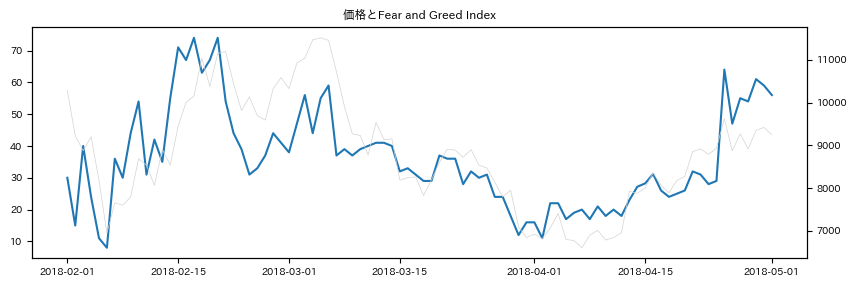

In [34]:
# 再びプロット.
fig = plt.figure(figsize=(10, 3))
plt.title('価格とFear and Greed Index')
plt.plot(df_fng['2018-02-01':'2018-05-01']['value'])
ax = fig.gca()
ax.twinx().plot(btcusdt['2018-02-01':'2018-05-01']['open_price'], color='lightgray', lw=0.5);

- 続いてvalue_classificationカラムの補完。
- 該当の値域は全て「Fear」となっているので、さくっと補完。

In [35]:
df_fng.query('value >= 27 & value <= 31')['value_classification'].value_counts()

value_classification
Fear    212
Name: count, dtype: int64

In [36]:
df_fng.loc['2018-04-14':'2018-04-16', 'value_classification'] = 'Fear'

In [37]:
# 欠損埋め完了.
df_fng['2018-04-10':'2018-04-20']

,value,value_classification
2018-04-10 00:00:00+00:00,18.000000,Extreme Fear
2018-04-11 00:00:00+00:00,20.000000,Extreme Fear
2018-04-12 00:00:00+00:00,18.000000,Extreme Fear
2018-04-13 00:00:00+00:00,23.000000,Extreme Fear
2018-04-14 00:00:00+00:00,27.178883,Fear
2018-04-15 00:00:00+00:00,28.244104,Fear
2018-04-16 00:00:00+00:00,31.199897,Fear
2018-04-17 00:00:00+00:00,26.000000,Fear
2018-04-18 00:00:00+00:00,24.000000,Extreme Fear
2018-04-19 00:00:00+00:00,25.000000,Extreme Fear


### 分布の確認

- 恐怖指数のラベルの分布

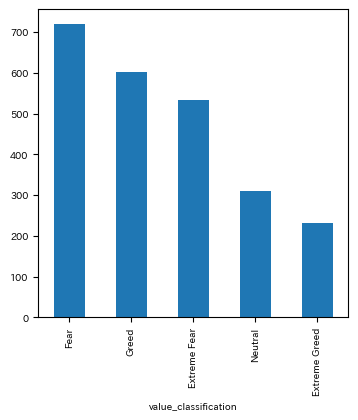

In [38]:
df_fng['value_classification'].value_counts().plot(kind='bar');

- 恐怖指数の値のヒストグラム

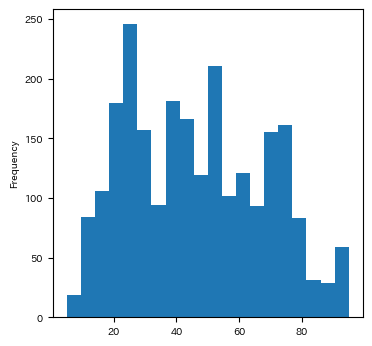

In [39]:
df_fng['value'].plot(kind='hist', bins=20);

### プロット

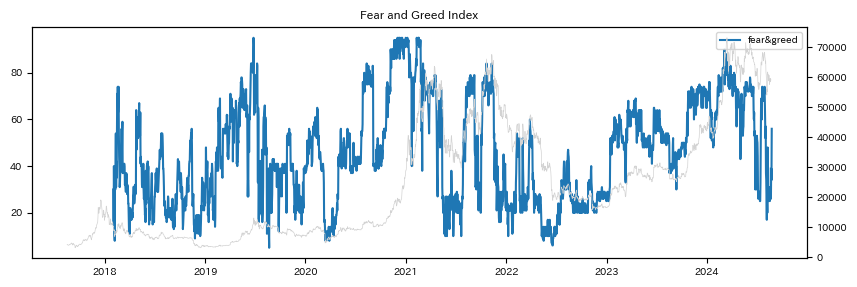

In [40]:
fig = plt.figure(figsize=(10, 3))
plt.title('Fear and Greed Index')
ax = fig.gca()
ax.plot(df_fng['value'], label='fear&greed')
ax.legend()
ax.twinx().plot(btcusdt['open_price'], color='lightgray', lw=0.5);

- 値は5～95。
- 上昇局面ではGreed寄り、下落局面ではFear寄りになっている感じはする。

# 2つの指標を比較する

- やりたいことは、「指標が底を示しているかどうか」を確認すること。
- とりあえず、価格水準と指標の水準を比較してみる。

## Volatility Index

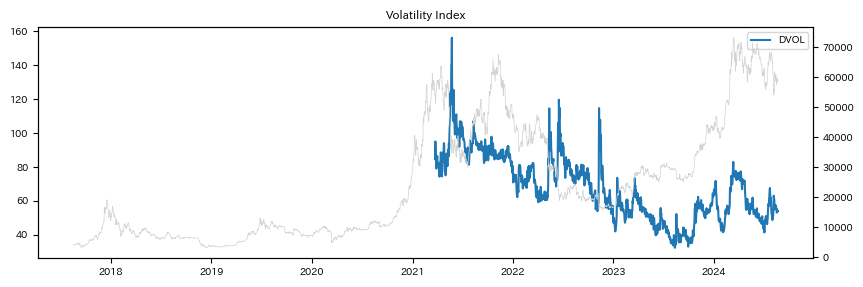

In [41]:
fig = plt.figure(figsize=(10, 3))
plt.title('Volatility Index')
ax = fig.gca()
ax.plot(df_dvol['dvol_open'], label='DVOL')
ax.legend()
ax_right = ax.twinx()
ax_right.plot(btcusdt['open_price'], color='lightgray', lw=0.5);

- 一定期間における価格とVIの順位相関を取ってみる

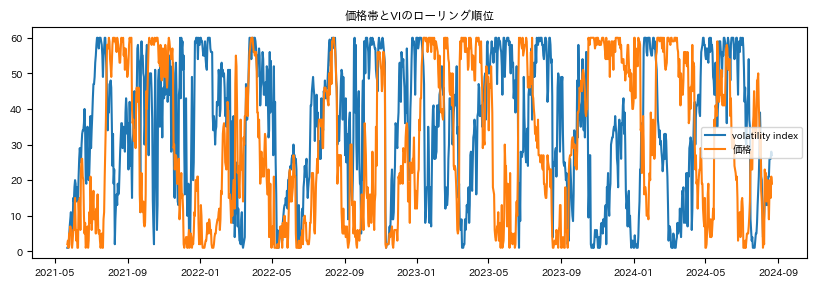

In [42]:
price_and_vi = btcusdt.copy()
price_and_vi['vi'] = df_dvol['dvol_open']
price_and_vi = price_and_vi.dropna()

fig = plt.figure(figsize=(10, 3))
plt.title('価格帯とVIのローリング順位')
plt.plot(price_and_vi['vi'].rolling(60).rank(ascending=False), label='volatility index')
plt.plot(price_and_vi['open_price'].rolling(60).rank(), label='価格')
plt.legend();

- 価格帯とVIの順位相関は高くない。

In [43]:
price_and_vi['vi'].rolling(60).rank(ascending=False).corr(price_and_vi['open_price'].rolling(60).rank())

-0.1438788894934437

## Fear and Greed Index

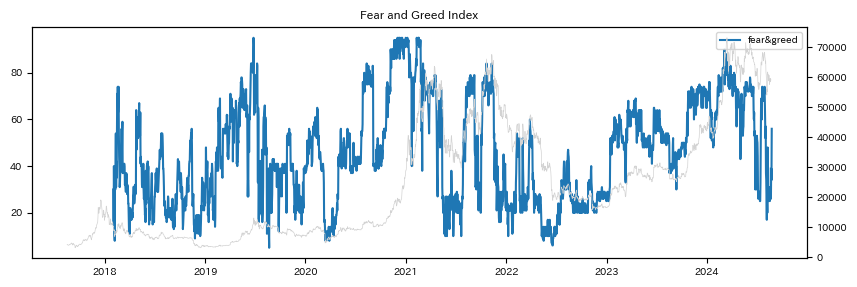

In [44]:
fig = plt.figure(figsize=(10, 3))
plt.title('Fear and Greed Index')
ax = fig.gca()
ax.plot(df_fng['value'], label='fear&greed')
ax.legend()
ax.twinx().plot(btcusdt['open_price'], color='lightgray', lw=0.5);

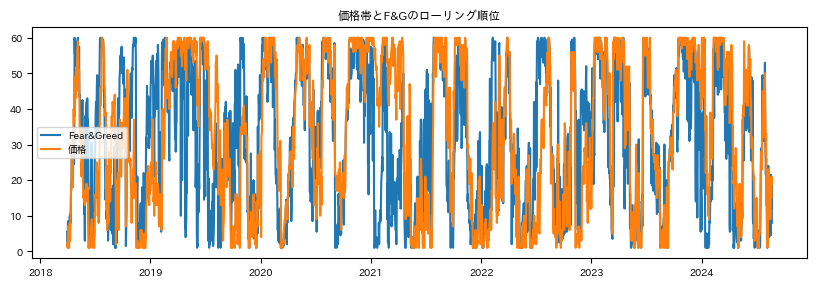

In [45]:
price_and_fng = btcusdt.copy()
price_and_fng['fng'] = df_fng['value']
price_and_fng = price_and_fng.dropna()

fig = plt.figure(figsize=(10, 3))
plt.title('価格帯とF&Gのローリング順位')
plt.plot(price_and_fng['fng'].rolling(60).rank(), label='Fear&Greed')
plt.plot(price_and_fng['open_price'].rolling(60).rank(), label='価格')
plt.legend();

- 価格帯とF&Gの順位相関は高い。

In [46]:
price_and_fng['fng'].rolling(60).rank().corr(price_and_fng['open_price'].rolling(60).rank())

0.6847090893906239

## まとめ

- 価格水準の説明として使いやすそうなのはVolatility IndexよりもFear and Greed Index。
- Fear and Greed Indexを使った簡単な戦略を立ててみる。

# Fear and Greed Indexの使いどころ

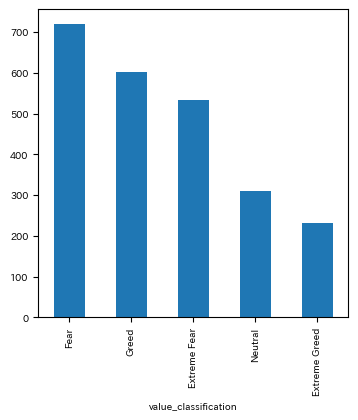

In [47]:
df_fng['value_classification'].value_counts().plot(kind='bar');

- 価格チャート上にプロットしてみる。
- 緑・・・Extreme Greed
- 橙・・・Fear
- 赤・・・Extreme Fear

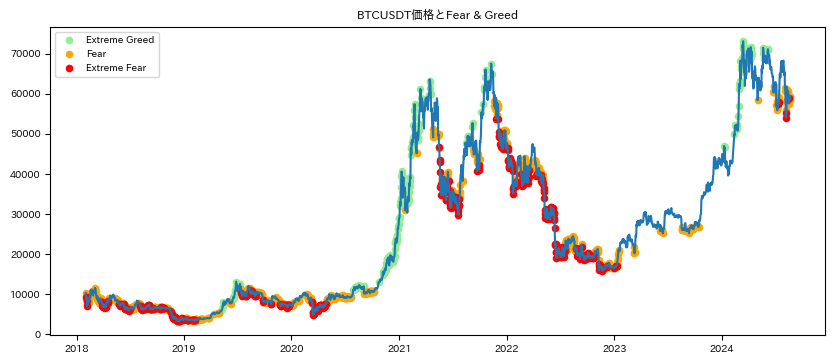

In [48]:
price_and_fear = btcusdt.copy()
price_and_fear['fear'] = df_fng['value_classification']
price_and_fear = price_and_fear.dropna()

fig = plt.figure(figsize=(10, 4))
plt.title('BTCUSDT価格とFear & Greed')
plt.scatter(price_and_fear[price_and_fear['fear'] == 'Extreme Greed'].index, price_and_fear[price_and_fear['fear'] == 'Extreme Greed']['open_price'], s=20, c='lightgreen', label='Extreme Greed')
plt.scatter(price_and_fear[price_and_fear['fear'] == 'Fear'].index, price_and_fear[price_and_fear['fear'] == 'Fear']['open_price'], s=20, c='orange', label='Fear')
plt.scatter(price_and_fear[price_and_fear['fear'] == 'Extreme Fear'].index, price_and_fear[price_and_fear['fear'] == 'Extreme Fear']['open_price'], s=20, c='red', label='Extreme Fear')
plt.plot(price_and_fear['open_price'])
plt.legend();

- 所感として、
  - 積み立てならFearで多めに積み立て、Greedで少な目に積み立ては、アリ。
  - 数日～数週間程度のスイングトレードの場合、逆張り的に使う（Fearで買ってHOLD、Greedで売ってHOLD）のは厳しそう。
  - 短期的な反発を狙えるか？

## 戦略1 トレンドフォロー的に使う

- Fear と Extreme Fearの間はショート
- Greed と Extreme Greedの間はロング
- Normal はその時点のポジションをキープ

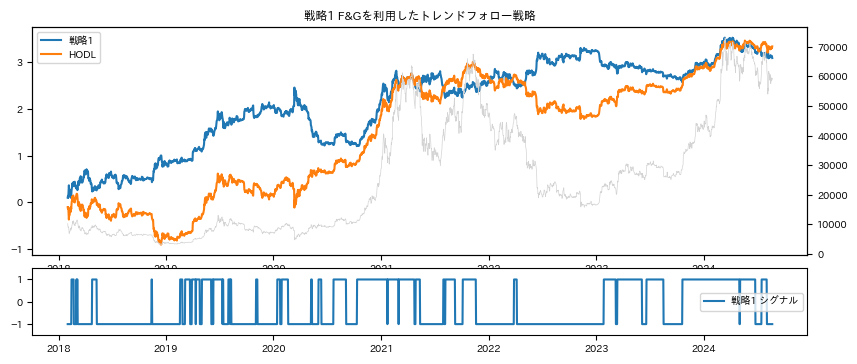

In [49]:
price_and_fear['fear_value'] = price_and_fear['fear'].map({'Extreme Fear': 1, 'Fear': 2, 'Neutral': 3, 'Greed': 4, 'Extreme Greed': 5})
price_and_fear['signal'] = None
price_and_fear.loc[price_and_fear['fear_value'] <= 2, 'signal'] = -1
price_and_fear.loc[price_and_fear['fear_value'] >= 4, 'signal'] = 1
price_and_fear['signal'] = price_and_fear['signal'].fillna(method='ffill').fillna(0)
price_and_fear['ret'] = (price_and_fear['close_price'] - price_and_fear['open_price']) / price_and_fear['open_price']
price_and_fear['pnl'] = price_and_fear['ret'] * price_and_fear['signal']
price_and_fear['signal_change'] = (price_and_fear['signal'] != price_and_fear['signal'].shift(1)).astype(int)
price_and_fear['trade_no'] = price_and_fear['signal_change'].cumsum()
trades = price_and_fear.groupby('trade_no').agg({'open_price': 'first', 'close_price': 'last', 'signal': 'first'})
trades['pnl'] = ((trades['close_price'] - trades['open_price']) / trades['open_price']) * trades['signal']

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.set_title('戦略1 F&Gを利用したトレンドフォロー戦略')
ax.plot(price_and_fear['pnl'].cumsum(), label='戦略1')
ax.plot(price_and_fear['ret'].cumsum(), label='HODL')
ax.legend()
ax.twinx().plot(price_and_fear['open_price'], color='lightgray', lw=0.5)
ax2 = plt.subplot2grid((4, 1), (3, 0))
ax2.plot(price_and_fear['signal'], label='戦略1 シグナル')
ax2.set_ylim(-1.5, 1.5)
ax2.legend();

In [50]:
def show_trade_result(trades):
    trades = trades[trades['signal'] != 0]
    total_count = len(trades)
    win_count = len(trades[trades['pnl'] > 0])
    lose_count = len(trades[trades['pnl'] < 0])
    pnl_ave = trades['pnl'].mean()
    win_pnl_ave =trades[trades['pnl'] > 0]['pnl'].mean()
    lose_pnl_ave =trades[trades['pnl'] < 0]['pnl'].mean()
    print(f'トレード数={total_count}, 勝ち数={win_count}, 負け数={lose_count}, 勝率={win_count/total_count*100:.2f}%')
    print(f'平均利益={pnl_ave:.4f}, Profit Factor={win_pnl_ave/(-lose_pnl_ave):.4f}')

In [51]:
show_trade_result(trades)

トレード数=71, 勝ち数=31, 負け数=40, 勝率=43.66%
平均利益=0.0621, Profit Factor=3.3175


### 所感

- なしではない。
- なるべくロバストな指標を用いたトレンドフォロー系の低レバ長期トレードは検討の余地あり、と考えている。そのひとつのヒントになるかもしれない。

- 以下は「トレンドフォロー系の低レバ長期トレード」の参考。
- 200日移動平均線の上下に応じて ロング or ショートしたときの累積リターン。

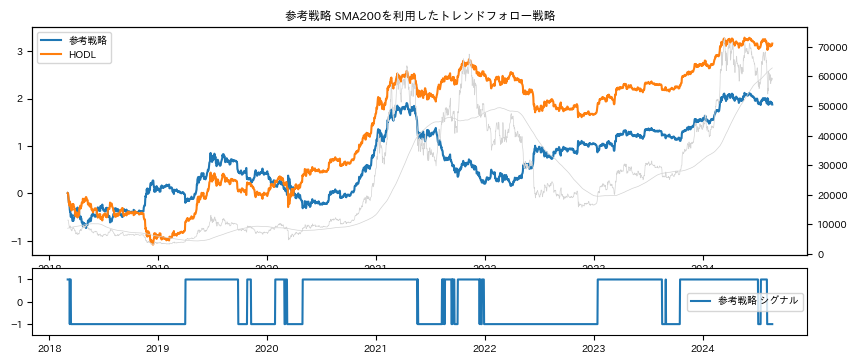

In [52]:
btcusdt_sma_stg = btcusdt.copy()
btcusdt_sma_stg['sma200'] = btcusdt_sma_stg['open_price'].rolling(200).mean()
btcusdt_sma_stg = btcusdt_sma_stg.dropna()
btcusdt_sma_stg['signal'] = 0
btcusdt_sma_stg.loc[btcusdt_sma_stg['sma200'] >= btcusdt_sma_stg['open_price'], 'signal'] = -1
btcusdt_sma_stg.loc[btcusdt_sma_stg['sma200'] < btcusdt_sma_stg['open_price'], 'signal'] = 1
btcusdt_sma_stg['signal'] = btcusdt_sma_stg['signal'].fillna(method='ffill')
btcusdt_sma_stg['ret'] = (btcusdt_sma_stg['close_price'] - btcusdt_sma_stg['open_price']) / btcusdt_sma_stg['open_price']
btcusdt_sma_stg['pnl'] = btcusdt_sma_stg['ret'] * btcusdt_sma_stg['signal']
btcusdt_sma_stg['signal_change'] = (btcusdt_sma_stg['signal'] != btcusdt_sma_stg['signal'].shift(1)).astype(int)
btcusdt_sma_stg['trade_no'] = btcusdt_sma_stg['signal_change'].cumsum()
trades = btcusdt_sma_stg.groupby('trade_no').agg({'open_price': 'first', 'close_price': 'last', 'signal': 'first'})
trades['pnl'] = ((trades['close_price'] - trades['open_price']) / trades['open_price']) * trades['signal']

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.set_title('参考戦略 SMA200を利用したトレンドフォロー戦略')
ax.plot(btcusdt_sma_stg['pnl'].cumsum(), label='参考戦略')
ax.plot(btcusdt_sma_stg['ret'].cumsum(), label='HODL')
ax.legend()
ax_right = ax.twinx()
ax_right.plot(btcusdt_sma_stg['open_price'], color='lightgray', lw=0.5)
ax_right.plot(btcusdt_sma_stg['sma200'], color='lightgray', lw=0.5)
ax2 = plt.subplot2grid((4, 1), (3, 0))
ax2.plot(btcusdt_sma_stg['signal'], label='参考戦略 シグナル')
ax2.set_ylim(-1.5, 1.5)
ax2.legend();

In [53]:
show_trade_result(trades)

トレード数=40, 勝ち数=7, 負け数=33, 勝率=17.50%
平均利益=0.0957, Profit Factor=12.3622


## 戦略2 短期逆張り指標に使う

- Extreme Fear時に数日ロング

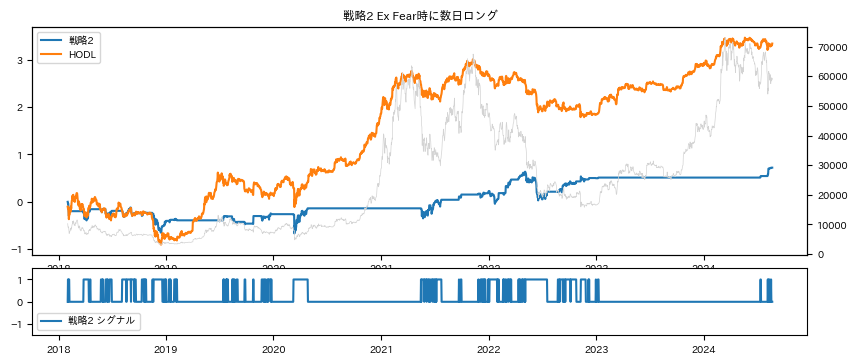

In [54]:
price_and_fear['signal'] = 0
price_and_fear.loc[price_and_fear['fear_value'] <= 1, 'signal'] = 1  # 1日目ロング
# price_and_fear.loc[price_and_fear['fear_value'].shift(1) <= 1, 'signal'] = 1  # 2日目ロング
# price_and_fear.loc[price_and_fear['fear_value'].shift(2) <= 1, 'signal'] = 1  # 3日目ロング
price_and_fear['ret'] = (price_and_fear['close_price'] - price_and_fear['open_price']) / price_and_fear['open_price']
price_and_fear['pnl'] = price_and_fear['ret'] * price_and_fear['signal']
price_and_fear['signal_change'] = (price_and_fear['signal'] != price_and_fear['signal'].shift(1)).astype(int)
price_and_fear['trade_no'] = price_and_fear['signal_change'].cumsum()
trades = price_and_fear.groupby('trade_no').agg({'open_price': 'first', 'close_price': 'last', 'signal': 'first'})
trades['pnl'] = ((trades['close_price'] - trades['open_price']) / trades['open_price']) * trades['signal']

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.set_title('戦略2 Ex Fear時に数日ロング')
ax.plot(price_and_fear['pnl'].cumsum(), label='戦略2')
ax.plot(price_and_fear['ret'].cumsum(), label='HODL')
ax.legend()
ax.twinx().plot(price_and_fear['open_price'], color='lightgray', lw=0.5)
ax2 = plt.subplot2grid((4, 1), (3, 0))
ax2.plot(price_and_fear['signal'], label='戦略2 シグナル')
ax2.set_ylim(-1.5, 1.5)
ax2.legend();

In [55]:
show_trade_result(trades)

トレード数=96, 勝ち数=64, 負け数=32, 勝率=66.67%
平均利益=0.0050, Profit Factor=0.6197


### 所感

- 自分としては戦略的にちょっと厳しい。
- エントリーが少ない、やられるときはやられる。
- ここぞというときにエントリーするような戦略としては、もう少しリスクリワードを高めたい。

- 以下は別の逆張り戦略の参考。
  - Extreme Fearになった時点でロング。
  - Normal以上に戻ってきたとき決済。
  - 普通に厳しい。

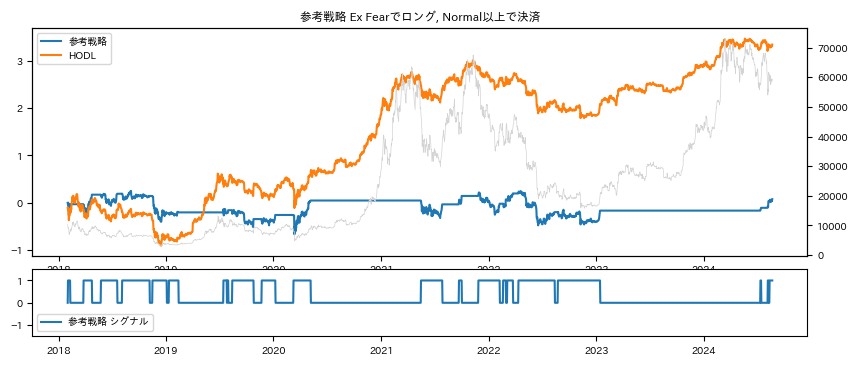

In [56]:
price_and_fear['signal'] = None
price_and_fear.loc[price_and_fear['fear_value'] <= 1, 'signal'] = 1  # Extreme Fearになった時点でロング
price_and_fear.loc[price_and_fear['fear_value'] >= 3, 'signal'] = 0  # Normal以上になった時点で決済
price_and_fear['signal'] = price_and_fear['signal'].fillna(method='ffill').fillna(0)
price_and_fear['ret'] = (price_and_fear['close_price'] - price_and_fear['open_price']) / price_and_fear['open_price']
price_and_fear['pnl'] = price_and_fear['ret'] * price_and_fear['signal']
price_and_fear['signal_change'] = (price_and_fear['signal'] != price_and_fear['signal'].shift(1)).astype(int)
price_and_fear['trade_no'] = price_and_fear['signal_change'].cumsum()
trades = price_and_fear.groupby('trade_no').agg({'open_price': 'first', 'close_price': 'last', 'signal': 'first'})
trades['pnl'] = ((trades['close_price'] - trades['open_price']) / trades['open_price']) * trades['signal']

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax.set_title('参考戦略 Ex Fearでロング, Normal以上で決済')
ax.plot(price_and_fear['pnl'].cumsum(), label='参考戦略')
ax.plot(price_and_fear['ret'].cumsum(), label='HODL')
ax.legend()
ax.twinx().plot(price_and_fear['open_price'], color='lightgray', lw=0.5)
ax2 = plt.subplot2grid((4, 1), (3, 0))
ax2.plot(price_and_fear['signal'], label='参考戦略 シグナル')
ax2.set_ylim(-1.5, 1.5)
ax2.legend();

In [57]:
show_trade_result(trades)

トレード数=21, 勝ち数=11, 負け数=10, 勝率=52.38%
平均利益=-0.0183, Profit Factor=0.6729


## 戦略3 積み立てに使う

- 毎日定額積み立ての場合。

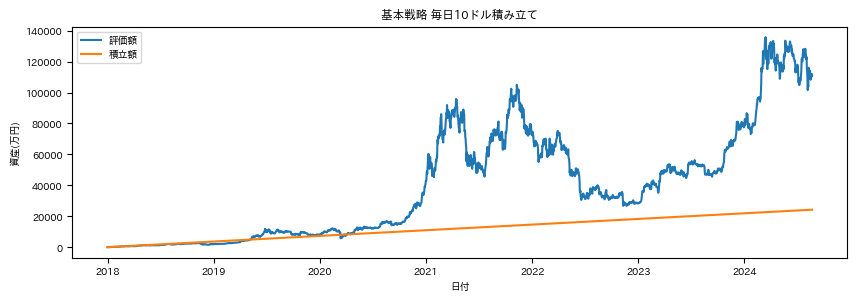

原資=24250, 評価額=111140, パフォーマンス=458.31%


In [58]:
btcusdt_base = btcusdt.copy()
btcusdt_base = btcusdt_base['2018':]
btcusdt_base['usd'] = 10
btcusdt_base['btc'] = btcusdt_base['usd'] / btcusdt_base['open_price']
btcusdt_base['total_usd'] = btcusdt_base['usd'].cumsum()
btcusdt_base['total_btc'] = btcusdt_base['btc'].cumsum()
btcusdt_base['portfolio_value'] = btcusdt_base['total_btc'] * btcusdt_base['open_price']

plt.figure(figsize=(10, 3))
plt.plot(btcusdt_base['portfolio_value'], label='評価額')
plt.plot(btcusdt_base['total_usd'], label='積立額')
plt.title('基本戦略 毎日10ドル積み立て')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.show()
print(f'原資={btcusdt_base["total_usd"][-1]:.0f}, 評価額={btcusdt_base["portfolio_value"][-1]:.0f}, パフォーマンス={btcusdt_base["portfolio_value"][-1] / btcusdt_base["total_usd"][-1] * 100:.2f}%')

- Fear and Greed Indexに応じて積立金額を変えた場合。

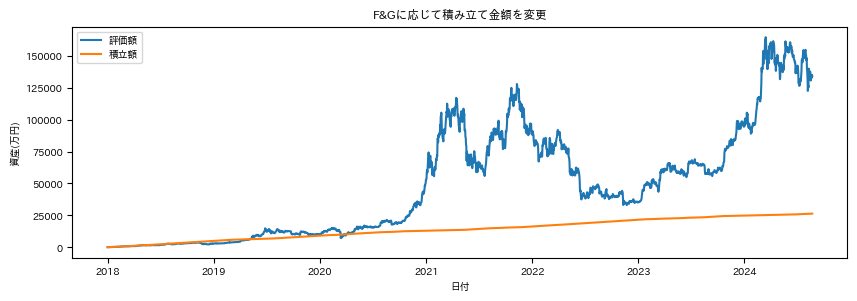

原資=26370, 評価額=134219, パフォーマンス=508.98%


In [59]:
btcusdt_stg1 = btcusdt.copy()
btcusdt_stg1 = btcusdt_stg1['2018':]
btcusdt_stg1['fng'] = df_fng['value']
btcusdt_stg1['usd'] = 10
btcusdt_stg1.loc[btcusdt_stg1['fng'] <= 50, 'usd'] = 15
btcusdt_stg1.loc[btcusdt_stg1['fng'] > 50, 'usd'] = 5
btcusdt_stg1['btc'] = btcusdt_stg1['usd'] / btcusdt_stg1['open_price']
btcusdt_stg1['total_usd'] = btcusdt_stg1['usd'].cumsum()
btcusdt_stg1['total_btc'] = btcusdt_stg1['btc'].cumsum()
btcusdt_stg1['portfolio_value'] = btcusdt_stg1['total_btc'] * btcusdt_stg1['open_price']

plt.figure(figsize=(10, 3))
plt.plot(btcusdt_stg1['portfolio_value'], label='評価額')
plt.plot(btcusdt_stg1['total_usd'], label='積立額')
plt.title('F&Gに応じて積み立て金額を変更')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.show()
print(f'原資={btcusdt_stg1["total_usd"][-1]:.0f}, 評価額={btcusdt_stg1["portfolio_value"][-1]:.0f}, パフォーマンス={btcusdt_stg1["portfolio_value"][-1] / btcusdt_stg1["total_usd"][-1] * 100:.2f}%')

- SMA200に応じて積立金額を変えた場合（前回の勉強会で登場）

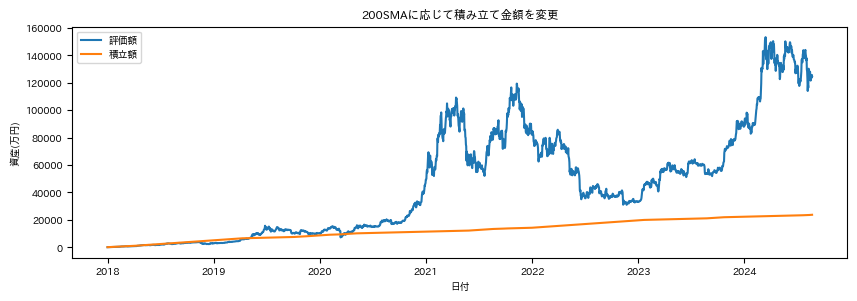

原資=23645, 評価額=124759, パフォーマンス=527.63%


In [60]:
btcusdt_stg2 = btcusdt.copy()
btcusdt_stg2['sma200'] = btcusdt_stg2['open_price'].rolling(200).mean()
btcusdt_stg2 = btcusdt_stg2['2018':]
btcusdt_stg2['usd'] = 10
btcusdt_stg2.loc[btcusdt_stg2['sma200'] >= btcusdt_stg2['open_price'], 'usd'] = 15
btcusdt_stg2.loc[btcusdt_stg2['sma200'] < btcusdt_stg2['open_price'], 'usd'] = 5

btcusdt_stg2['btc'] = btcusdt_stg2['usd'] / btcusdt_stg2['open_price']
btcusdt_stg2['total_usd'] = btcusdt_stg2['usd'].cumsum()
btcusdt_stg2['total_btc'] = btcusdt_stg2['btc'].cumsum()
btcusdt_stg2['portfolio_value'] = btcusdt_stg2['total_btc'] * btcusdt_stg2['open_price']

plt.figure(figsize=(10, 3))
plt.plot(btcusdt_stg2['portfolio_value'], label='評価額')
plt.plot(btcusdt_stg2['total_usd'], label='積立額')
plt.title('200SMAに応じて積み立て金額を変更')
plt.xlabel('日付')
plt.ylabel('資産(万円)')
plt.legend()
plt.show()
print(f'原資={btcusdt_stg2["total_usd"][-1]:.0f}, 評価額={btcusdt_stg2["portfolio_value"][-1]:.0f}, パフォーマンス={btcusdt_stg2["portfolio_value"][-1] / btcusdt_stg2["total_usd"][-1] * 100:.2f}%')

- 3者のパフォーマンスを比較してみる。

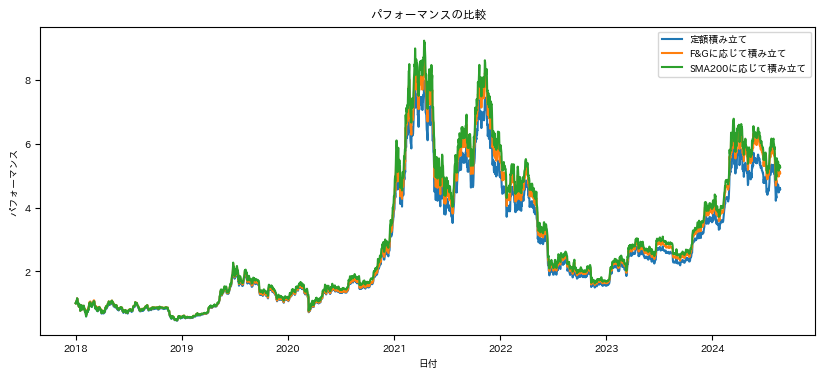

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(btcusdt_base['portfolio_value'] / btcusdt_base['total_usd'], label='定額積み立て')
plt.plot(btcusdt_stg1['portfolio_value'] / btcusdt_stg1['total_usd'], label='F&Gに応じて積み立て')
plt.plot(btcusdt_stg2['portfolio_value'] / btcusdt_stg2['total_usd'], label='SMA200に応じて積み立て')
plt.title('パフォーマンスの比較')
plt.xlabel('日付')
plt.ylabel('パフォーマンス')
plt.legend()
plt.show()

- 2024年以降をアップで。

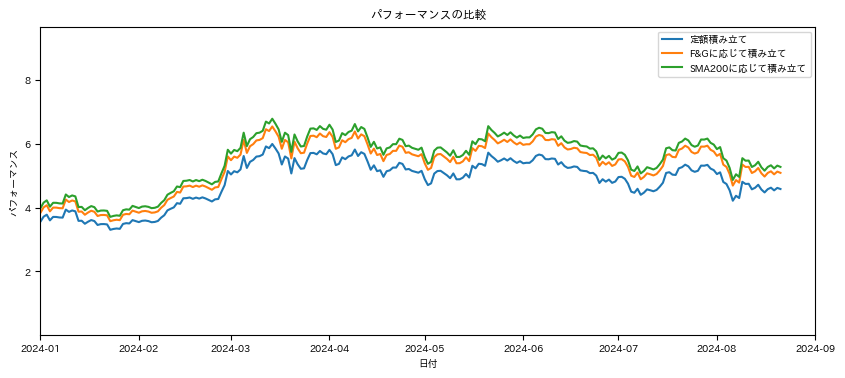

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(btcusdt_base['portfolio_value'] / btcusdt_base['total_usd'], label='定額積み立て')
plt.plot(btcusdt_stg1['portfolio_value'] / btcusdt_stg1['total_usd'], label='F&Gに応じて積み立て')
plt.plot(btcusdt_stg2['portfolio_value'] / btcusdt_stg2['total_usd'], label='SMA200に応じて積み立て')
plt.title('パフォーマンスの比較')
plt.xlabel('日付')
plt.ylabel('パフォーマンス')
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-09-01'))
plt.legend()
plt.show()

### 所感

- Fear and Greed Indexは、一応価格帯が上がり過ぎの水準か下がり過ぎの水準かの指標として一応機能している。
- 積み立てするときの指標の候補にはなりうる。

# 今日のまとめ

- Volatility Index と Fear and Greed Indexの違い
  - 使い分けが必要
  - 価格帯の指標にするならFear and Greed Index
  - ボラティリティ系戦略ならVolatility Index
- 「極度の恐怖では価格は反発するのか？」のテーマに対しては、
  - Fear状態、Greed状態は一定期間続き、その間価格トレンドが形成される可能性がある。
  - 一時的には反発もあり得るが、長めの期間で考えたときは逆らわないほうがよい。

# 次回

- 来週は予定があるのでお休みする予定です。
- 4回目は再来週の予定。お楽しみに！